In [174]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#model and tools
from scipy.optimize import curve_fit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

# Upload the data

In [2]:
orders = pd.read_csv('orders.csv')
orders.date = pd.to_datetime(orders.date)
orders.head()

,delivery_area_id,date,orders_cnt
0,0,2021-04-01 10:00:00,9
1,0,2021-04-01 11:00:00,1
2,0,2021-04-01 13:00:00,1
3,0,2021-04-01 14:00:00,1
4,0,2021-04-01 15:00:00,2


In [3]:
df_train = orders[(orders.date >= pd.to_datetime('2021-11-01')) & (orders.date < pd.to_datetime('2021-11-24'))]
df_test = orders[(orders.date >= pd.to_datetime('2021-11-24')) & (orders.date < pd.to_datetime('2021-12-01'))]

# Selection of areas with big number of orders

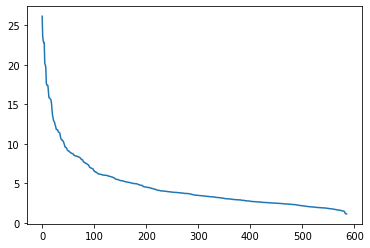

In [4]:
df_train_const = df_train.groupby(by='delivery_area_id', as_index=False).mean()

df_train_const_sort = df_train.groupby(by='delivery_area_id').mean()
df_train_const_sort = df_train_const_sort.sort_values(by='orders_cnt', ascending=False, ignore_index=True)
plt.plot(df_train_const_sort)

Thus we have about 50 areas with average number of orders bigger than 10.

In [5]:
df_train_const = df_train_const[df_train_const.orders_cnt >= 10]
df_train_const.head(20)

,delivery_area_id,orders_cnt
1,1,11.505455
3,4,14.223827
4,5,15.496377
7,8,11.843636
8,9,11.432886
9,10,11.763699
13,14,15.858621
16,17,23.022876
18,19,17.384615
19,20,17.413043


In [6]:
df_train = df_train[df_train.delivery_area_id.isin(df_train_const.delivery_area_id)]
df_test = df_test[df_test.delivery_area_id.isin(df_train_const.delivery_area_id)]

# Data normalization

In [7]:
for area in df_train_const.delivery_area_id.unique():
    norm = df_train_const[df_train_const.delivery_area_id==area].orders_cnt.to_list()[0]
    df_train.orders_cnt[df_train.delivery_area_id==area] = df_train.orders_cnt[df_train.delivery_area_id==area] / norm
    df_test.orders_cnt[df_test.delivery_area_id==area] = df_test.orders_cnt[df_test.delivery_area_id==area] / norm

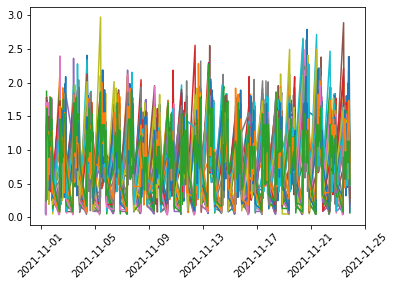

In [8]:
for area in df_train.delivery_area_id.unique():
    df = df_train[df_train.delivery_area_id==area]
    x, y = df.date, df.orders_cnt
    plt.plot(x, y)
    plt.xticks(rotation = 45)
plt.show()

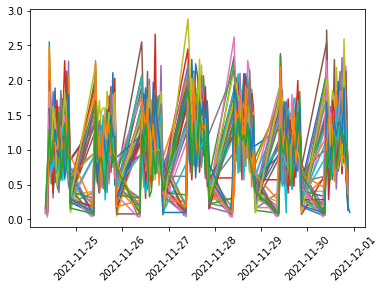

In [9]:
for area in df_test.delivery_area_id.unique():
    df = df_test[df_test.delivery_area_id==area]
    x, y = df.date, df.orders_cnt
    plt.plot(x, y)
    plt.xticks(rotation = 45)
plt.show()

So here we can see that the number of orders is periodical series and looks like stationar time-series.

# Stationarity check

p-value for original series of delivery area 1 0.0014782890428184444
p-value for original series of delivery area 4 0.0042425262901996845
p-value for original series of delivery area 5 0.0016935038275640358
p-value for original series of delivery area 8 0.02621850156239672
p-value for original series of delivery area 9 0.0298609914715747
p-value for original series of delivery area 10 0.13787721986849916
p-value for original series of delivery area 14 0.03006929338436301
p-value for original series of delivery area 17 0.05613068328732872
p-value for original series of delivery area 19 0.09376948305902155
p-value for original series of delivery area 20 0.17922425110366136
p-value for original series of delivery area 21 0.04943776642283956
p-value for original series of delivery area 23 0.009233280246076812
p-value for original series of delivery area 24 0.017913998114195147
p-value for original series of delivery area 25 0.020792848231124393
p-value for original series of delivery area 

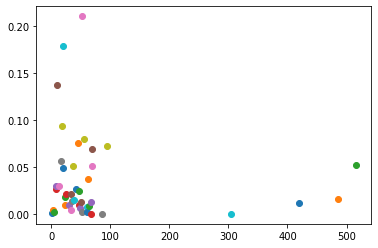

In [10]:
for area in df_test.delivery_area_id.unique():
    df = df_train[df_train.delivery_area_id==area]
    x_train, y_train = df.date, df.orders_cnt
    #df = df_test[df_test.delivery_area_id==area]
    #x_test, y_test = df.date, df.orders_cnt
    
    result = adfuller(y_train)
    print('p-value for original series of delivery area '+str(area), result[1])
    plt.scatter(area, result[1])

Here we can see that in general time series with zero order differencing is stationar. So we will use original timeseries.

# ARIMA model. Grid search p, q.

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
areas = np.array(df_test.delivery_area_id.unique())

In [13]:
p_range = np.arange(1, 18, 2)
q_range = np.arange(1, 28, 13)
MAPEs = np.empty(shape=((len(p_range)), len(q_range)))

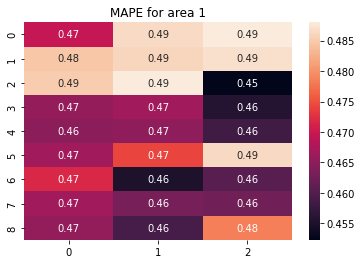

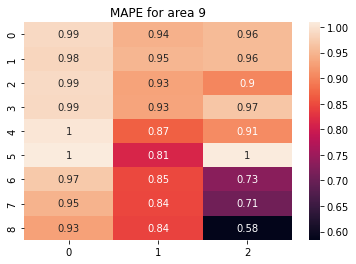

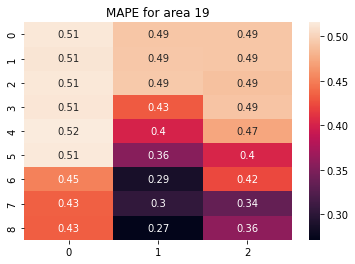

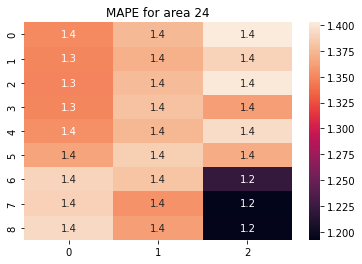

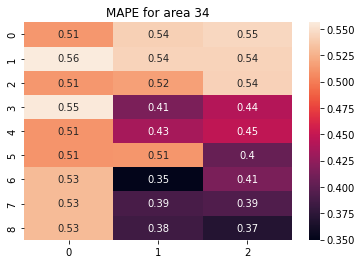

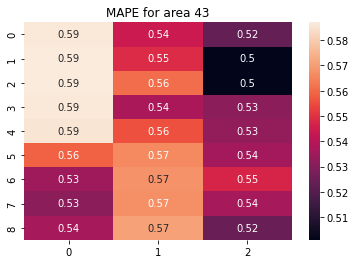

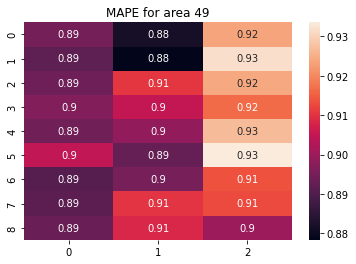

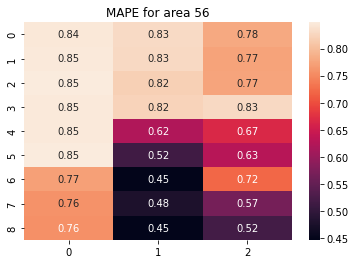

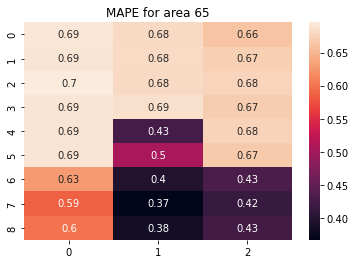

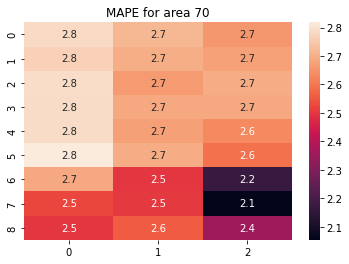

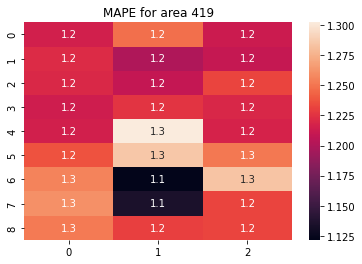

In [14]:
for area in areas[::4]:
    df = df_train[df_train.delivery_area_id==area]
    x_train, y_train = df.date, df.orders_cnt
    df = df_test[df_test.delivery_area_id==area]
    x_test, y_test = df.date, df.orders_cnt

    for idx_p, p in zip(range(len(p_range)), p_range):
        for idx_q, q in zip(range(len(q_range)), q_range):
            arima_model = ARIMA(y_train, order=(p, 0, q))
            model = arima_model.fit()

            y_pred = model.predict(start=len(x_train), end=len(x_train)+len(x_test)-1)
            mape = mean_absolute_percentage_error(y_test, y_pred)
            MAPEs[idx_p, idx_q] = mape
            #print(p, q, mape)
            
    sns.heatmap(MAPEs, annot=True)
    plt.title('MAPE for area '+str(area))
    plt.show()

In [15]:
p_range = np.arange(18, 21, 1)
q_range = np.arange(12, 15, 1)
MAPEs = np.empty(shape=((len(p_range)), len(q_range)))

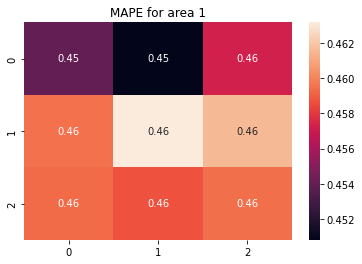

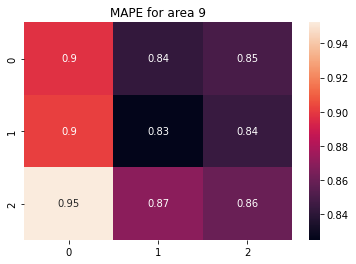

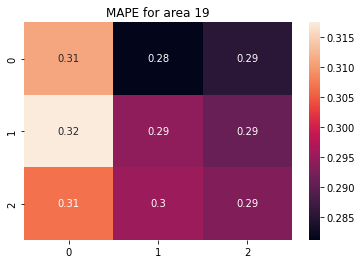

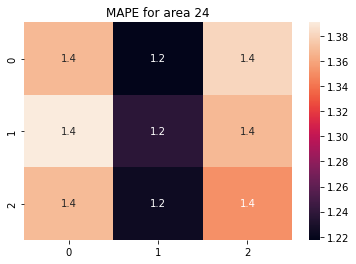

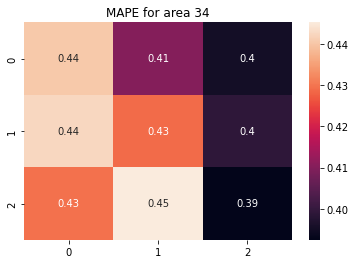

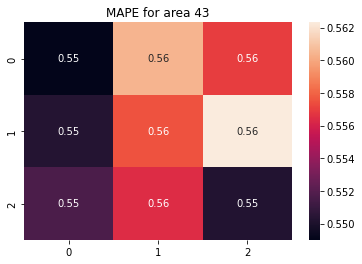

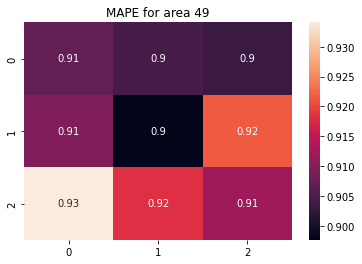

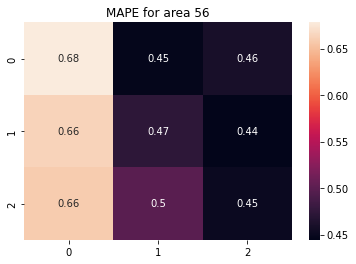

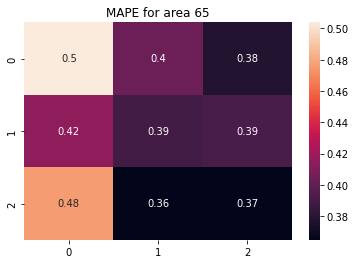

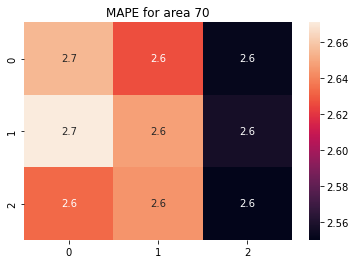

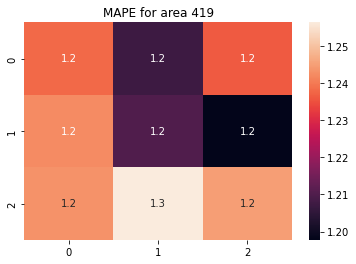

In [16]:
for area in areas[::4]:
    df = df_train[df_train.delivery_area_id==area]
    x_train, y_train = df.date, df.orders_cnt
    df = df_test[df_test.delivery_area_id==area]
    x_test, y_test = df.date, df.orders_cnt

    for idx_p, p in zip(range(len(p_range)), p_range):
        for idx_q, q in zip(range(len(q_range)), q_range):
            arima_model = ARIMA(y_train, order=(p, 0, q))
            model = arima_model.fit()

            y_pred = model.predict(start=len(x_train), end=len(x_train)+len(x_test)-1)
            mape = mean_absolute_percentage_error(y_test, y_pred)
            MAPEs[idx_p, idx_q] = mape
            #print(p, q, mape)
            
    sns.heatmap(MAPEs, annot=True)
    plt.title('MAPE for area '+str(area))
    plt.show()

So we will use ARIMA(18, 0, 13)

# Exapmle of ARIMA forecasting

In [17]:
area = 4
df = df_train[df_train.delivery_area_id==area]
x_train, y_train = df.date, df.orders_cnt
df = df_test[df_test.delivery_area_id==area]
x_test, y_test = df.date, df.orders_cnt

In [18]:
arima_model = ARIMA(y_train, order=(18, 0, 13))
model = arima_model.fit()

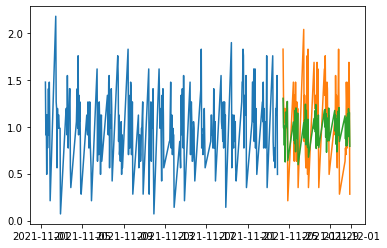

In [19]:
y_pred = model.predict(start=len(x_train), end=len(x_train)+len(x_test)-1)
plt.plot(x_train, y_train)
plt.plot(x_test, y_test)
plt.plot(x_test, y_pred)
plt.show()

In [20]:
mean_absolute_percentage_error(y_test, y_pred)

0.37219962916180666

# Delays overview

In [90]:
orders = pd.read_csv('orders.csv')
orders.date = pd.to_datetime(orders.date)
print(delays.date.dtype)
orders.head()

datetime64[ns]


,delivery_area_id,date,orders_cnt
0,0,2021-04-01 10:00:00,9
1,0,2021-04-01 11:00:00,1
2,0,2021-04-01 13:00:00,1
3,0,2021-04-01 14:00:00,1
4,0,2021-04-01 15:00:00,2


In [91]:
delays = pd.read_csv('partners_delays.csv')
delays = delays.rename(columns={'dttm': 'date'})
delays.date = pd.to_datetime(delays.date)
print(delays.date.dtype)
delays.head()

datetime64[ns]


,delivery_area_id,date,partners_cnt,delay_rate
0,0,2021-04-01 09:00:00,3.0,0.000000
1,0,2021-04-01 10:00:00,4.0,0.111111
2,0,2021-04-01 11:00:00,4.0,0.000000
3,0,2021-04-01 12:00:00,4.0,0.000000
4,0,2021-04-01 13:00:00,1.0,0.000000


In [92]:
orders = orders[(orders.date >= pd.to_datetime('2021-11-08')) & (orders.date < pd.to_datetime('2021-12-01'))]
orders = orders[orders.delivery_area_id.isin(df_train_const.delivery_area_id)]
delays = delays[(delays.date >= pd.to_datetime('2021-11-08')) & (delays.date < pd.to_datetime('2021-12-01'))]
delays = delays[delays.delivery_area_id.isin(df_train_const.delivery_area_id)]

In [93]:
orders

,delivery_area_id,date,orders_cnt
5522,1,2021-11-08 10:00:00,17
5523,1,2021-11-08 11:00:00,14
5524,1,2021-11-08 12:00:00,10
5525,1,2021-11-08 13:00:00,14
5526,1,2021-11-08 14:00:00,15
...,...,...,...
802699,516,2021-11-30 17:00:00,16
802700,516,2021-11-30 18:00:00,15
802701,516,2021-11-30 19:00:00,14
802702,516,2021-11-30 20:00:00,14


In [94]:
delays

,delivery_area_id,date,partners_cnt,delay_rate
6510,1,2021-11-08 08:00:00,1.0,0.000000
6511,1,2021-11-08 09:00:00,1.0,0.000000
6512,1,2021-11-08 10:00:00,7.0,0.176471
6513,1,2021-11-08 11:00:00,7.0,0.142857
6514,1,2021-11-08 12:00:00,6.0,0.100000
...,...,...,...,...
1118555,516,2021-11-30 18:00:00,7.0,0.133333
1118556,516,2021-11-30 19:00:00,6.0,0.071429
1118557,516,2021-11-30 20:00:00,6.0,0.214286
1118558,516,2021-11-30 21:00:00,4.0,0.111111


In [101]:
df = orders.join(delays.set_index(['delivery_area_id', 'date']), 
              on=['delivery_area_id', 'date'], how='inner', lsuffix='_caller', rsuffix='_other')#, on=['delivery_area_id', 'date'])
df

,delivery_area_id,date,orders_cnt,partners_cnt,delay_rate
5522,1,2021-11-08 10:00:00,17,7.0,0.176471
5523,1,2021-11-08 11:00:00,14,7.0,0.142857
5524,1,2021-11-08 12:00:00,10,6.0,0.100000
5525,1,2021-11-08 13:00:00,14,6.0,0.142857
5526,1,2021-11-08 14:00:00,15,6.0,0.000000
...,...,...,...,...,...
802699,516,2021-11-30 17:00:00,16,7.0,0.187500
802700,516,2021-11-30 18:00:00,15,7.0,0.133333
802701,516,2021-11-30 19:00:00,14,6.0,0.071429
802702,516,2021-11-30 20:00:00,14,6.0,0.214286


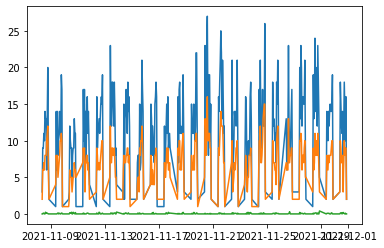

In [124]:
for area in [9]:
    tmp = df[df.delivery_area_id==area]
    plt.plot(tmp.date, tmp.orders_cnt)
    plt.plot(tmp.date, tmp.partners_cnt)
    plt.plot(tmp.date, tmp.delay_rate)
    plt.show()

# Interesting correlations in data

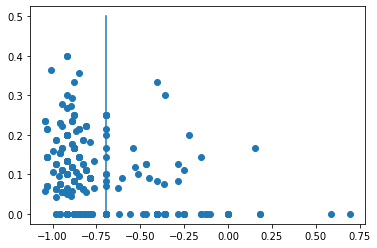

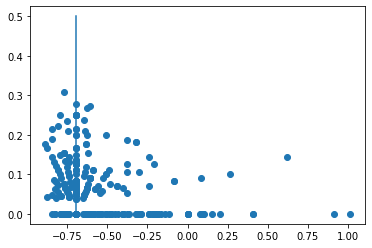

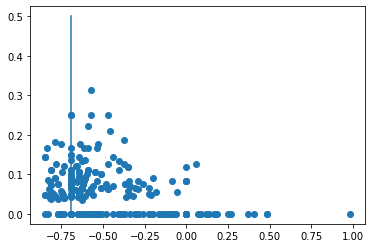

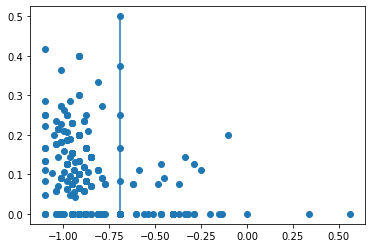

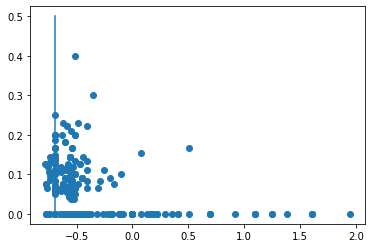

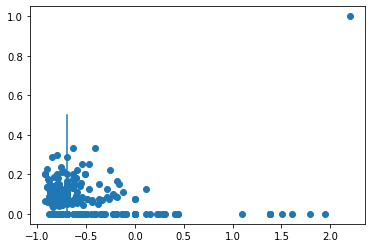

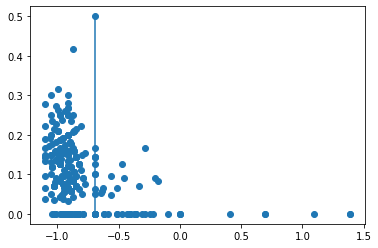

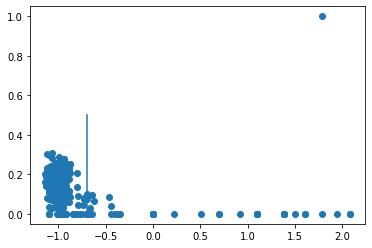

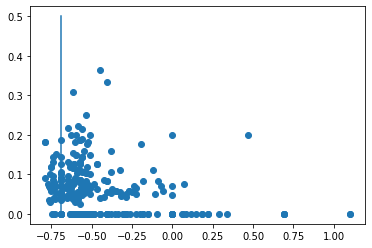

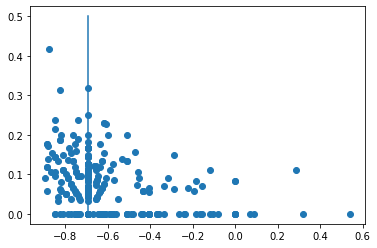

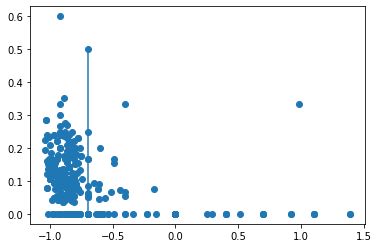

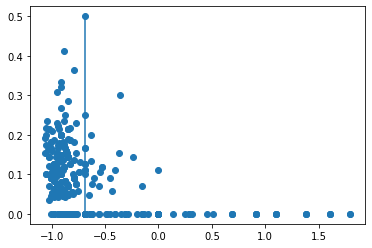

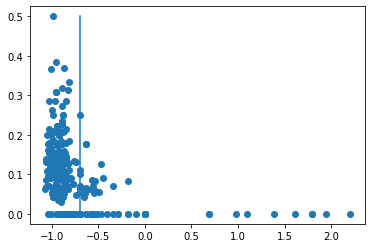

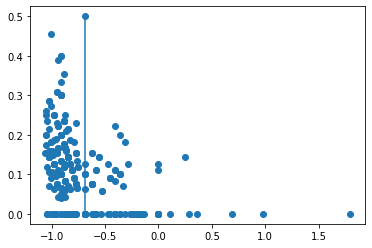

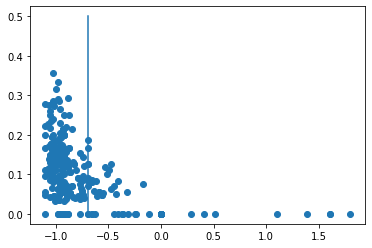

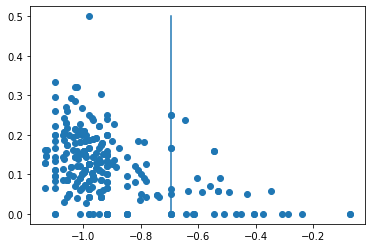

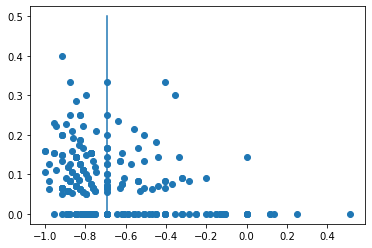

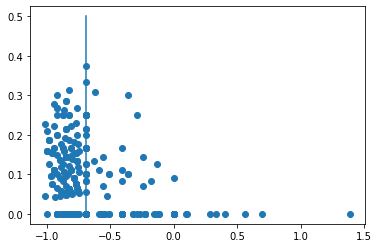

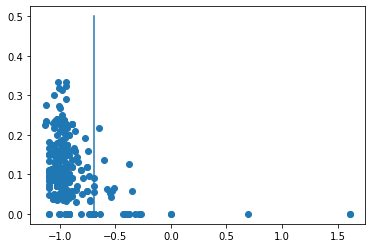

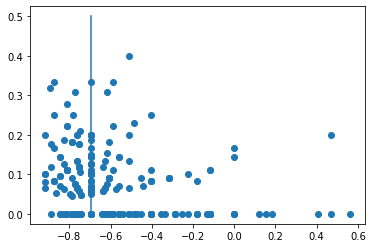

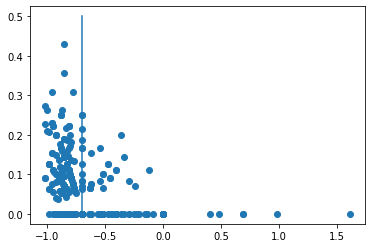

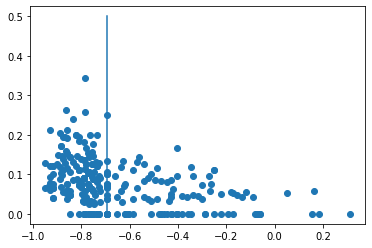

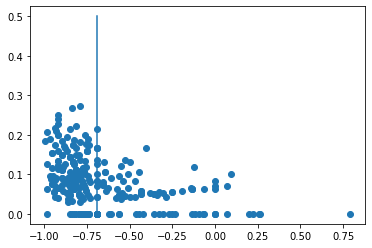

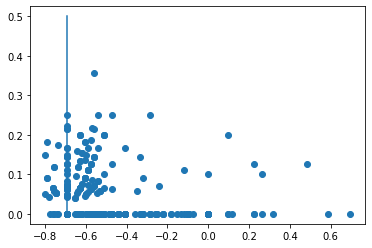

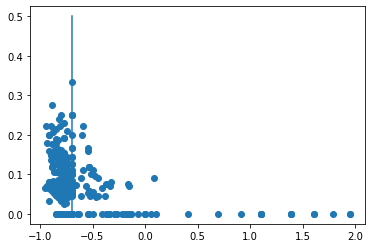

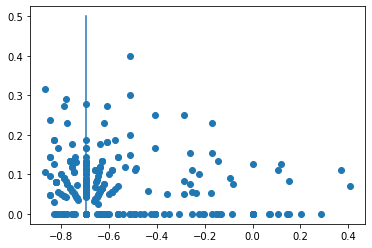

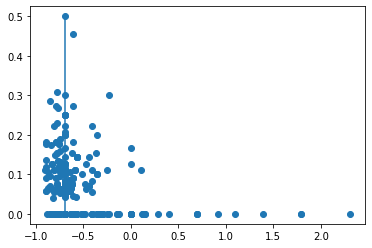

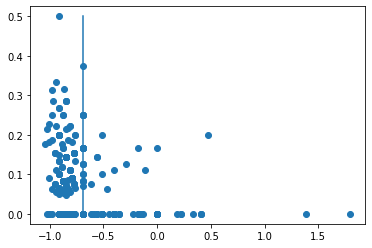

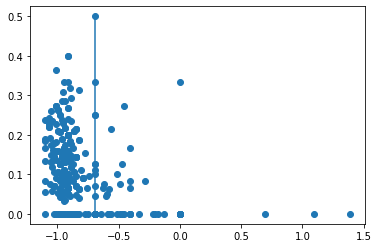

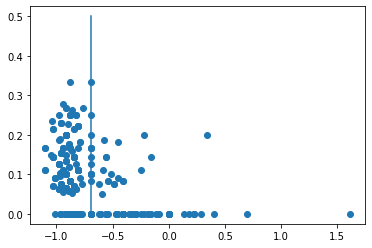

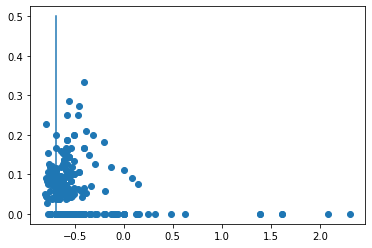

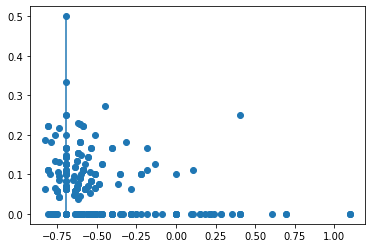

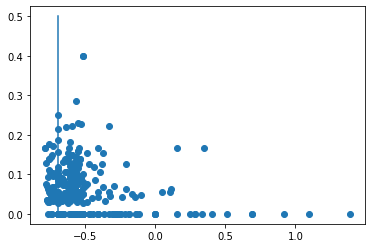

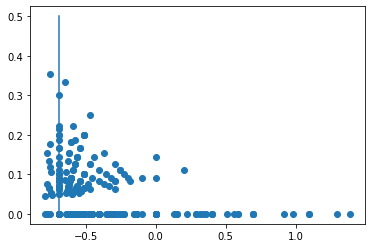

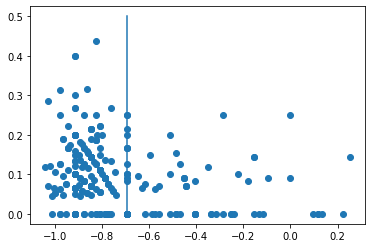

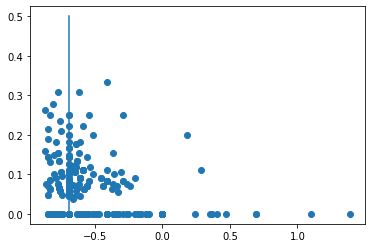

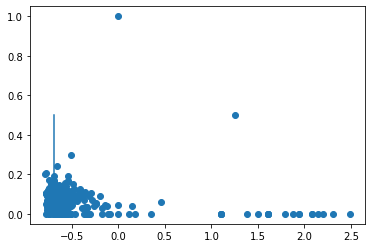

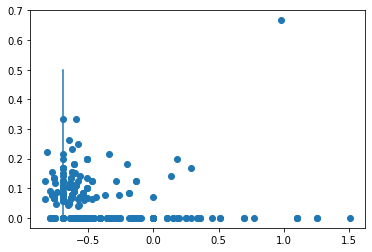

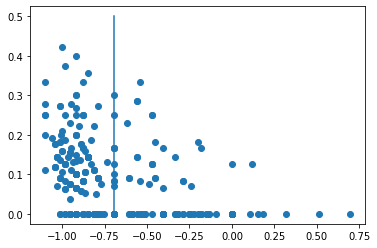

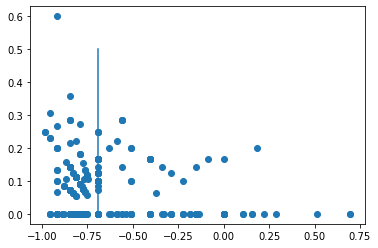

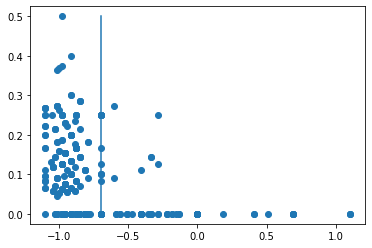

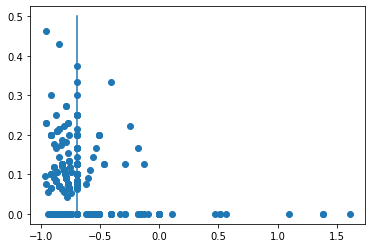

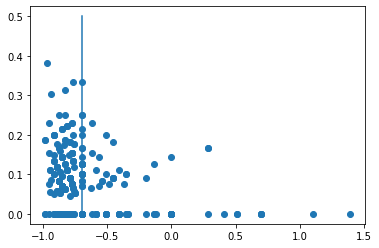

In [111]:
for area in areas:
    tmp = df[df.delivery_area_id==area]
    plt.scatter(np.log(tmp.partners_cnt/tmp.orders_cnt), tmp.delay_rate)
    plt.plot(np.log(0.5)*np.ones(shape=2), [0, 0.5])
    plt.show()

At that graphs we can see interesting structure of data. We assume that it connected with system of timetabeling, which logically ensure low delay rate for periodically reapeating times with big number of orders.

Moreover we can see that level of 0.5 partner_cnt/order_cnt is such kind of warning signal for company. So we can see it from graph

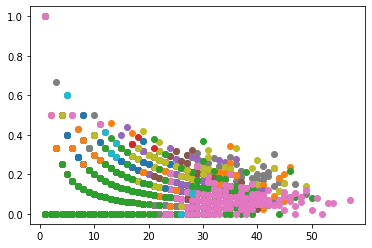

In [127]:
for area in areas:
    tmp = df[df.delivery_area_id==area]
    plt.scatter((tmp.orders_cnt), (tmp.delay_rate))
plt.show()

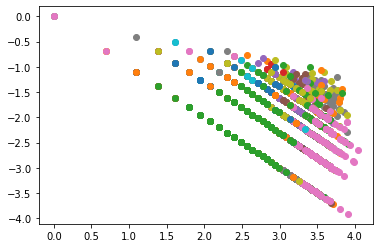

In [128]:
for area in areas:
    tmp = df[df.delivery_area_id==area]
    plt.scatter(np.log(tmp.orders_cnt), np.log(tmp.delay_rate))
plt.show()

So here from the graph we can see that company make optimization which hyperbola(each hyperbola defined by number of partners) will minimize the delay rate and will be the smallest hyperbola(in meaning of the smallest number of partners)

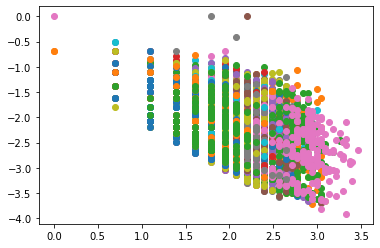

In [139]:
for area in areas:
    tmp = df[df.delivery_area_id==area]
    plt.scatter(np.log(tmp.partners_cnt), np.log(tmp.delay_rate))
plt.show()

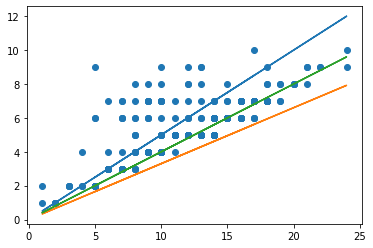

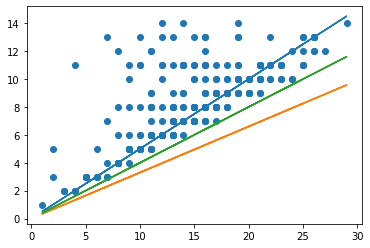

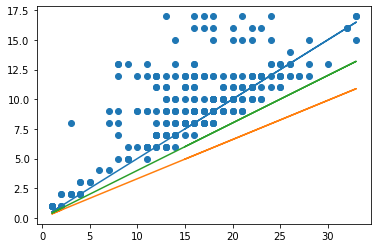

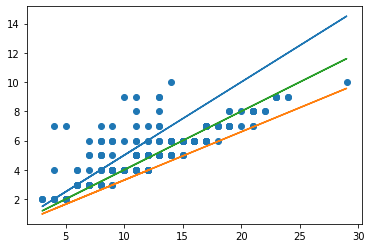

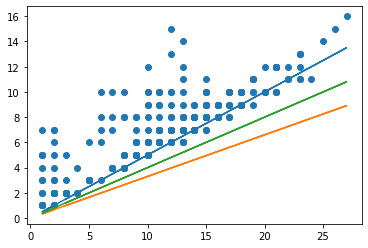

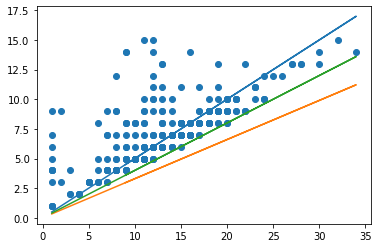

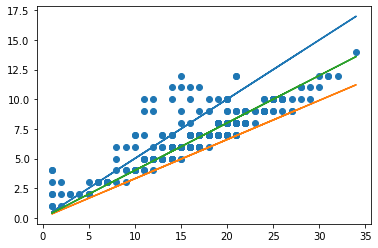

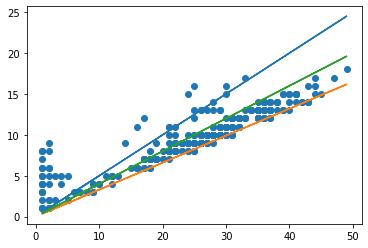

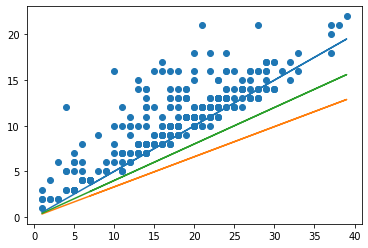

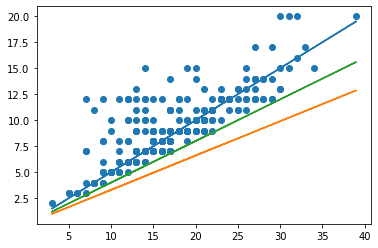

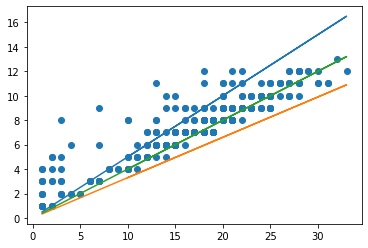

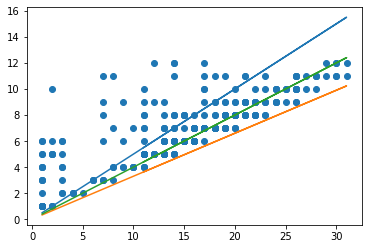

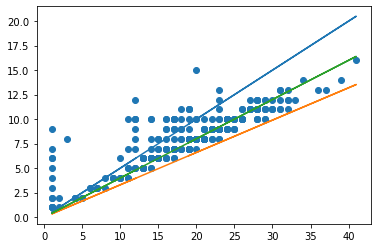

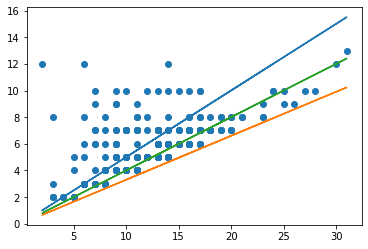

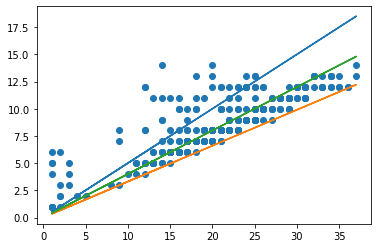

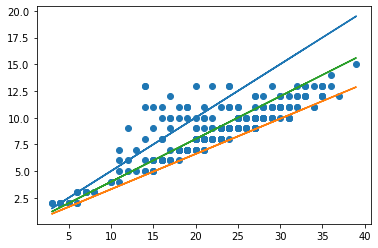

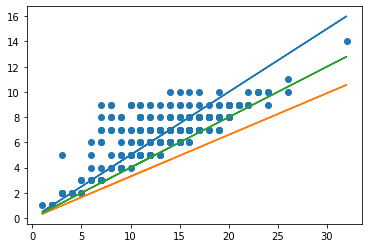

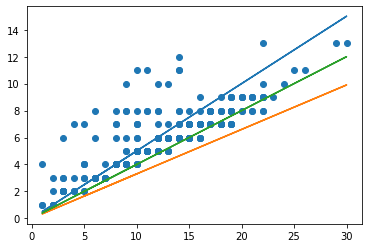

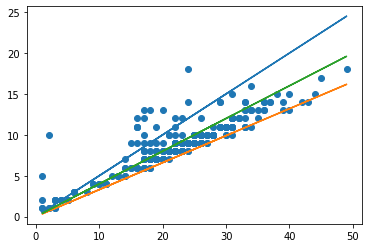

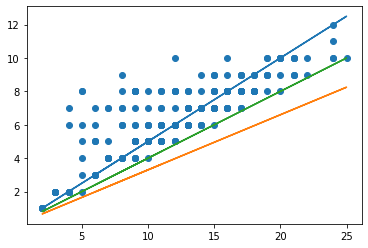

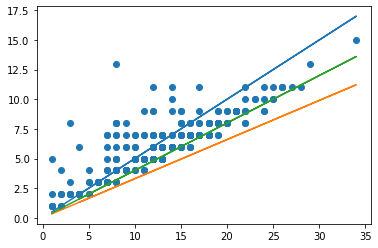

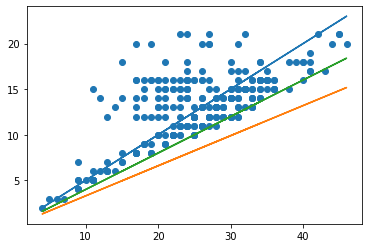

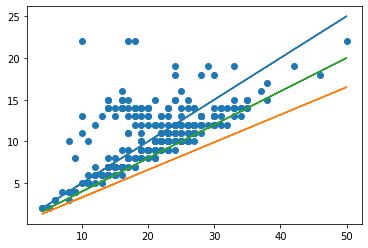

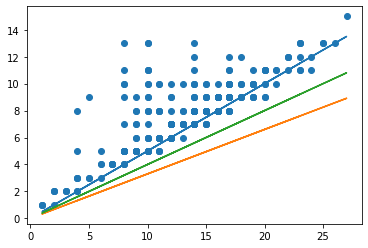

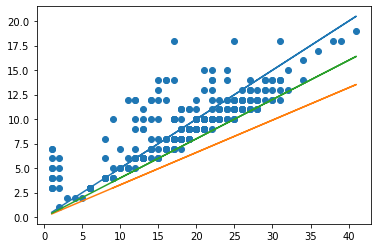

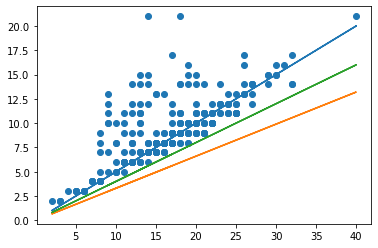

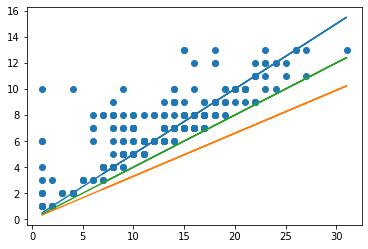

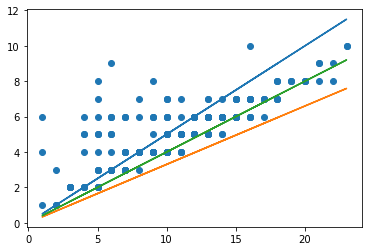

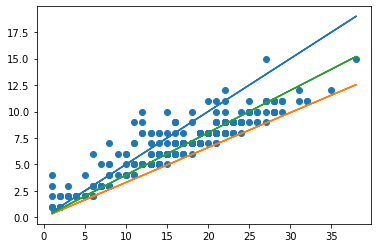

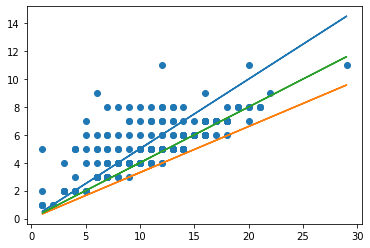

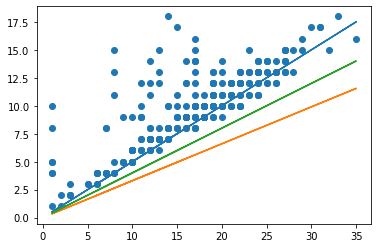

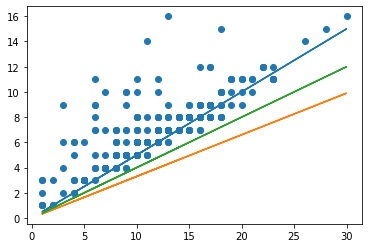

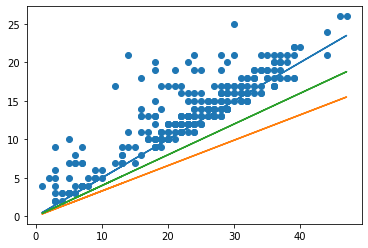

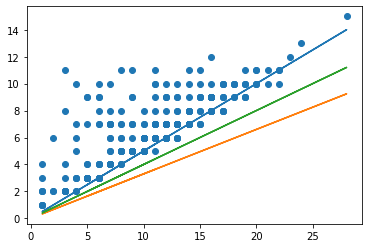

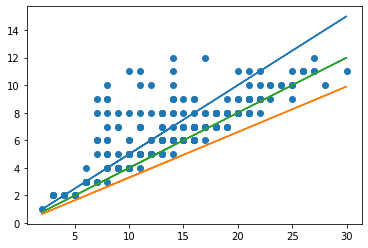

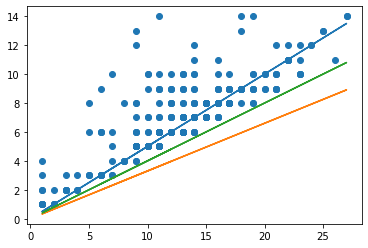

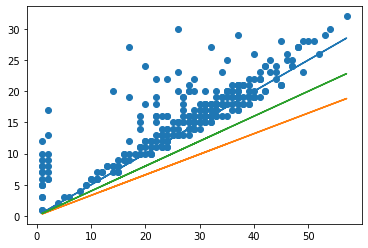

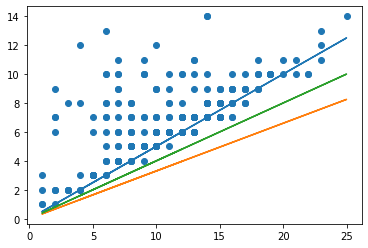

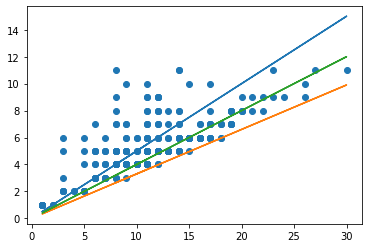

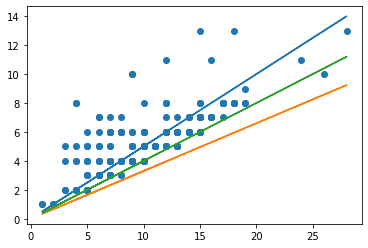

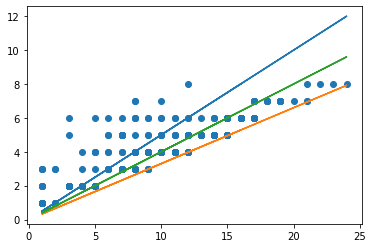

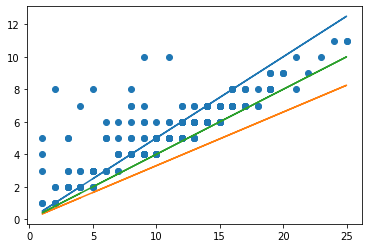

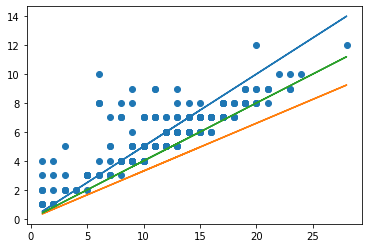

In [147]:
for area in areas:
    tmp = df[df.delivery_area_id==area]
    plt.scatter((tmp.orders_cnt), (tmp.partners_cnt))
    plt.plot((tmp.orders_cnt), 0.5*(tmp.orders_cnt))
    plt.plot((tmp.orders_cnt), 0.33*(tmp.orders_cnt))
    plt.plot((tmp.orders_cnt), 0.4*(tmp.orders_cnt))
    plt.show()

So here we can see that in  general this strategy realized. May by all cities clusterized into groups where relations of orders and partners can't be bigger than some value.

# Timetable analysis

In [171]:
timetable = df.groupby(by=['delivery_area_id'], as_index=False).mean()
timetable.head()

,delivery_area_id,orders_cnt,partners_cnt,delay_rate
0,1,11.665455,5.403636,0.094471
1,4,14.599278,8.191336,0.064943
2,5,16.050909,9.574545,0.054655
3,8,12.271739,5.195652,0.105875
4,9,11.643333,7.150000,0.052057


From that timetable we can see how many partners is working in average

# The dependance of delay rate

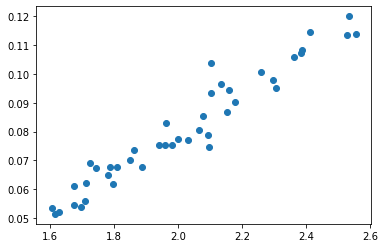

In [173]:
plt.scatter(timetable.orders_cnt/timetable.partners_cnt, timetable.delay_rate)

So in general we can say that we have linear dependance between the delay rate and number of orders per partner.

X-axis intersection: 0.8436367418205869


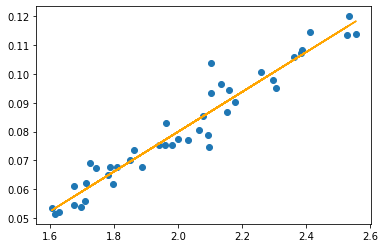

In [179]:
def linear(x, a, b): return a*x + b

x, y = timetable.orders_cnt/timetable.partners_cnt, timetable.delay_rate

popt, pcov = curve_fit(linear, x, y)

plt.scatter(x, y)
plt.plot(x, linear(x, *popt), c='orange')

a, b = popt
print('X-axis intersection:', -b/a)

So we assume that with the ratio of orders per partner around 0.84 we will not have any delay.